In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns
from sklearn import metrics
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if False and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
def Train(model_name, num_classes, feature_extract, data_dir, batch_size=10, num_epochs=15, use_pretrained=True):

  # Initialize the model for this run
  model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

  ## Print the model we just instantiated
  print(model_ft)

  # Data augmentation and normalization for training
  # Just normalization for validation
  data_transforms = {
      'train': transforms.Compose([
          #transforms.RandomResizedCrop(input_size),
          #transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          #transforms.Resize(input_size),
          #transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  print("Initializing Datasets and Dataloaders...")

  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

  # Create training and validation dataloaders
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

  # Detect if we have a GPU available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Send the model to GPU
  model_ft = model_ft.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

  # Setup the loss fxn
  criterion = nn.CrossEntropyLoss()

  # Train and evaluate
  model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
  return model_ft

In [ ]:
# Prediction and Conf matrix
def get_all_preds(model, data_dir):
    data_transforms = {
    'val': transforms.Compose([
        #transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(1),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}
    image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
    loader = torch.utils.data.DataLoader(image_datasets, batch_size=30, shuffle=True, num_workers=2)
    model = model.to("cpu")
    model.eval()
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch
        with torch.no_grad():
          preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
        del preds
        torch.cuda.empty_cache()

    all_preds_np = all_preds.cpu().detach().numpy()
    all_labels_np = all_labels.cpu().detach().numpy()
    return all_preds_np, all_labels_np

def plot_conf(Y_pred, Y_label):
  LABELS = ['bend','lie','nfall','sitstand','stand','turn','walk']
  Y_label_int = Y_label#np.argmax(Y_label, axis=1)
  Y_pred_int = np.argmax(Y_pred, axis=1)
  confusion_matrix = metrics.confusion_matrix(Y_label_int, Y_pred_int)
  #confusion_matrix[3,0] = confusion_matrix[3,0]
  plt.figure(figsize=(6, 4))
  sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
  plt.title("Confusion matrix")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show();

  Acc = np.trace(confusion_matrix) / np.sum(confusion_matrix)
  print('Accuracy: {:.4f}'.format(Acc))


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

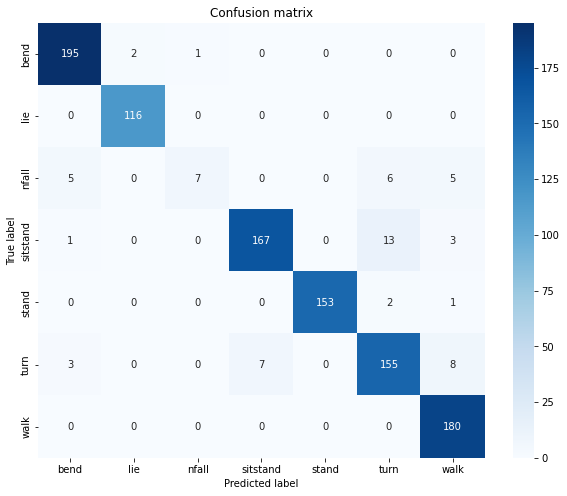

Accuracy: 0.9447


In [ ]:
## Train on HG Data w/o feature extraction

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = False

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_squeezenet_false")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_squeezenet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

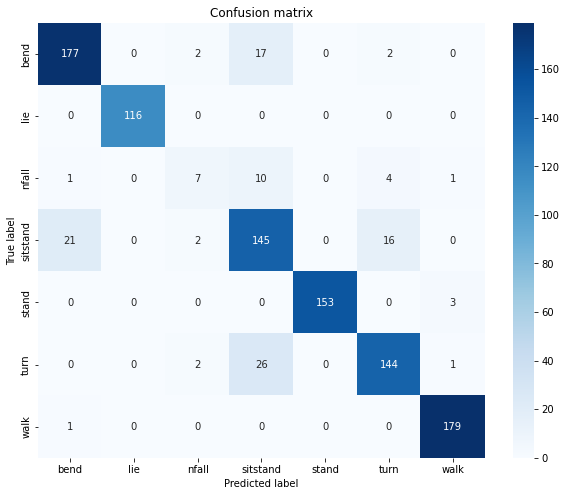

Accuracy: 0.8942


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

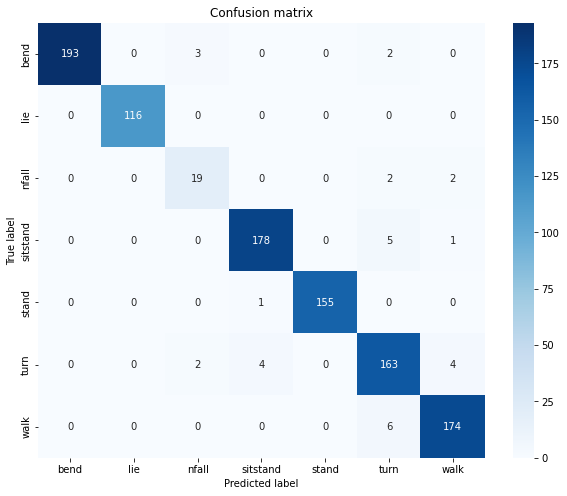

Accuracy: 0.9689


In [ ]:
## Train on HG Data w/o feature extraction

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = False

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

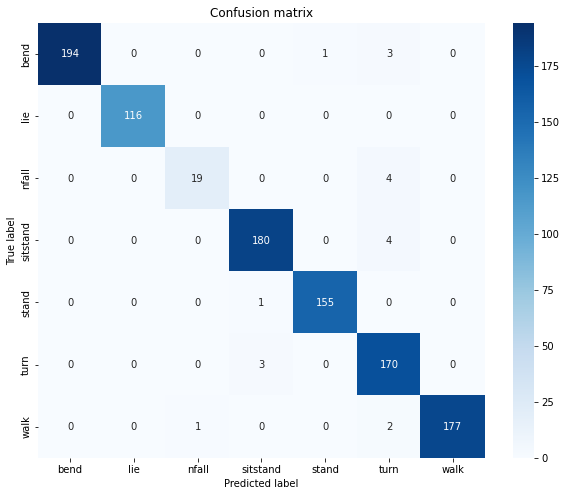

Accuracy: 0.9816


In [ ]:
## Train on HG Data w/o Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"
num_classes = 7
batch_size = 30
num_epochs = 13
feature_extract = False

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_densenet_false")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_densenet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

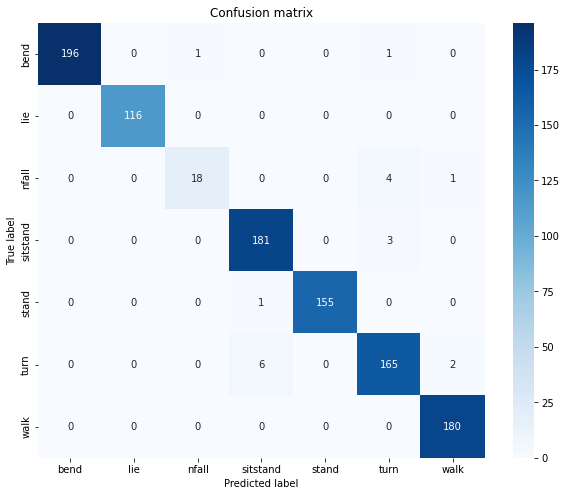

Accuracy: 0.9816


In [ ]:
## Train on HG Data w/o Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
num_classes = 7
batch_size = 30
num_epochs = 14
feature_extract = False

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_false")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

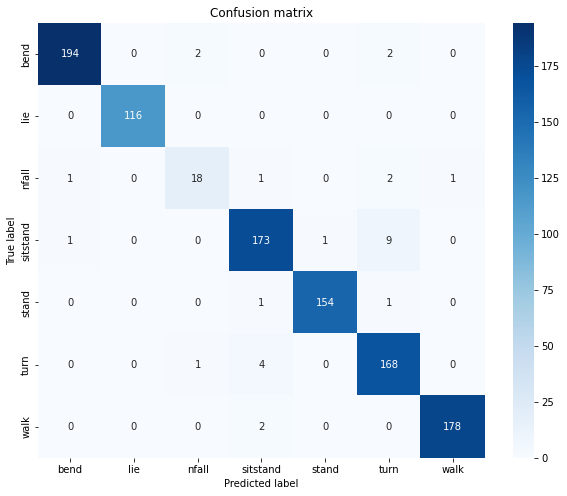

Accuracy: 0.9718


In [ ]:
## Train on HG Data w/o Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
num_classes = 7
batch_size = 50
num_epochs = 15
feature_extract = False

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_vgg_false")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_vgg_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 1.2496 Acc: 0.5015
val Loss: 0.9157 Acc: 0.6223

Epoch 1/14
----------
train Loss: 0.9461 Acc: 0.6130
val Loss: 0.9926 Acc: 0.6087

Epoch 2/14
----------
train Loss: 0.8403 Acc: 0.6660
val Loss: 0.8978 Acc: 0.6379

Epoch 3/14
----------
train Loss: 0.8261 Acc: 0.6582
val Loss: 0.7419 Acc: 0.6874

Epoch 4/14
----------
train Loss: 0.7543 Acc: 0.6831
val Loss: 0.7895 Acc: 0.6893

Epoch 5/14
----------
train Loss: 0.7603 Acc: 0.6821
val Loss: 0.6350 Acc: 0.7359

Epoch 6/14
----------
train Loss: 0.7034 Acc: 0.7069
val Loss: 0.7654 Acc: 0.6864

Epoch 7/14
----------
train Loss: 0.7176 Acc: 0.6938
val Loss: 0.6642 Acc: 0.7136

Epoch 8/14
----------
train Loss: 0.6888 Acc: 0.7191
val Loss: 0.6170 Acc: 0.7631

Epoch 9/14
----------
train Loss: 0.6873 Acc: 0.7040
val Loss: 0.6816 Acc: 0.7291

Epoch 10/14
----------
train Loss: 0.6567 Acc: 0.7244
val Loss: 0.6265 Acc: 0.7379

Epoch 11/14
----------
train Loss: 0.6749 Acc: 0.7118
val Loss: 0.6016 Acc: 0.7631

Epoch 12/14
----------
t

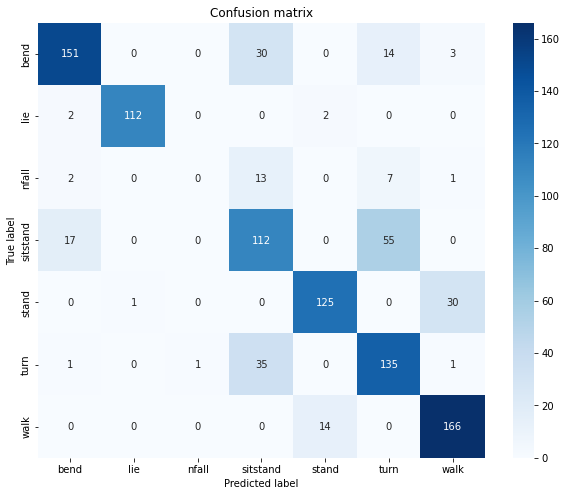

Accuracy: 0.7777


In [ ]:
## Train on HG Data w Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"
num_classes = 7
batch_size = 8
num_epochs = 15
feature_extract = True

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_squeezenet_true")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_squeezenet_true")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

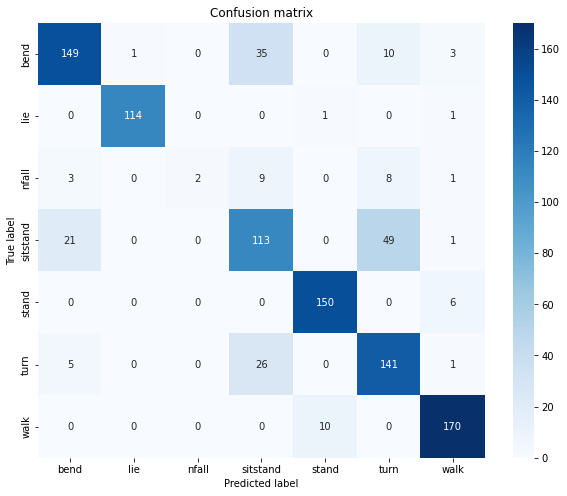

Accuracy: 0.8146


In [ ]:
## Train on HG Data w Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = True

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_true")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_true")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

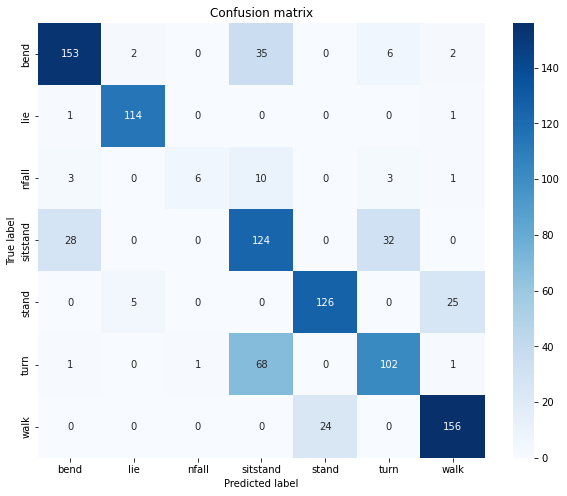

Accuracy: 0.7583


In [ ]:
## Train on HG Data w Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = True

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_true")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_true")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

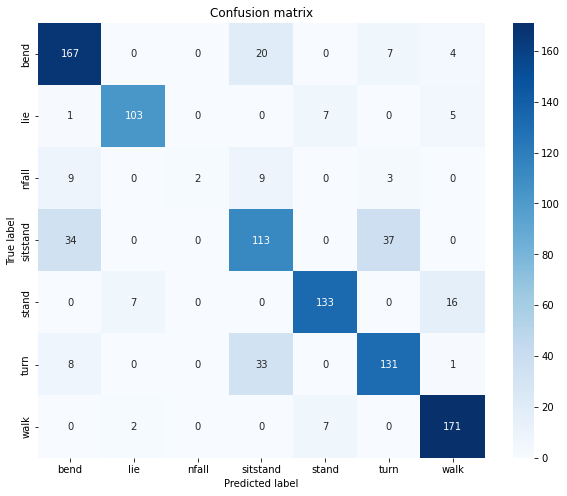

Accuracy: 0.7961


In [ ]:
## Train on HG Data w Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = True

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_densenet_true")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_densenet_true")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

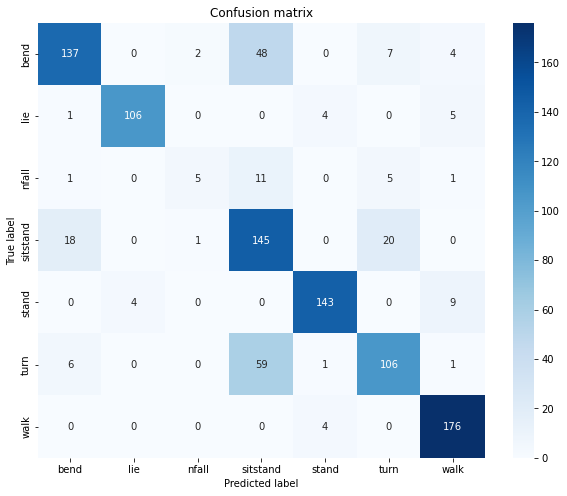

Accuracy: 0.7942


In [ ]:
## Train on HG Data w Feature extraact
#   to the ImageFolder structure
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
num_classes = 7
batch_size = 30
num_epochs = 20
feature_extract = True

model_ft = Train(model_name, num_classes, feature_extract, data_dir, batch_size, num_epochs, use_pretrained=True)

torch.save(model_ft, "drive/MyDrive/Thesis/Codes/ImageNet/HG_vgg_true")
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_vgg_true")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

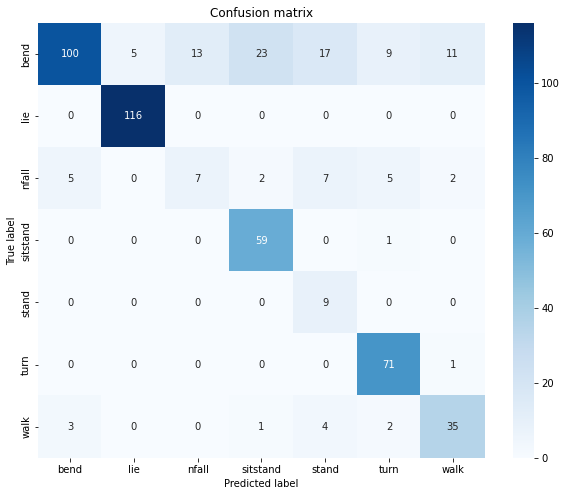

Accuracy: 0.7815


In [ ]:
### CHECK ON NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

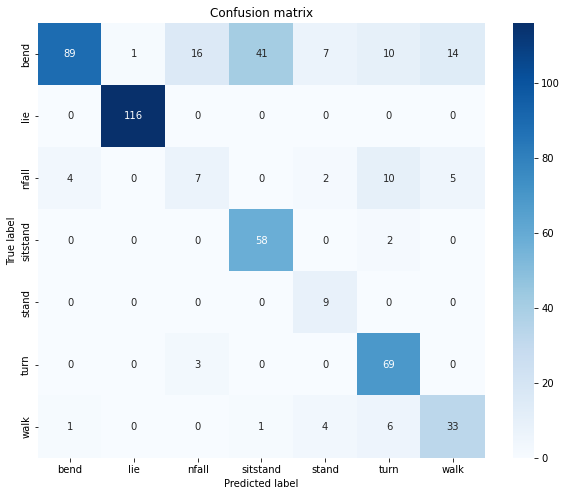

Accuracy: 0.7500


In [ ]:
### CHECK ON NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

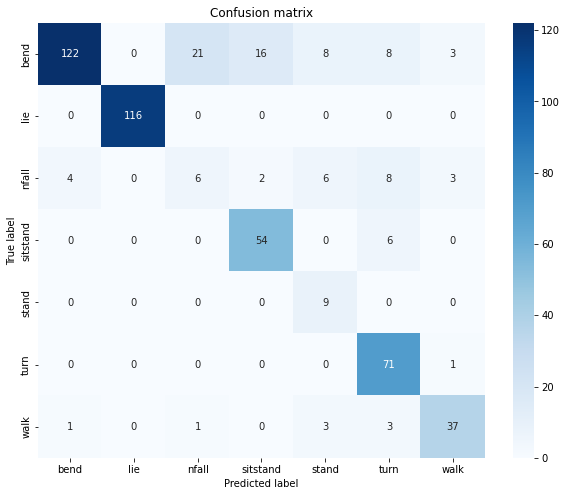

Accuracy: 0.8153


In [ ]:
### CHECK ON NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_vgg_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

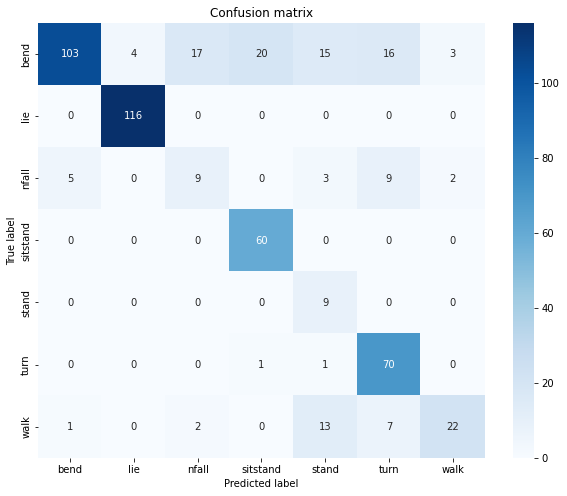

Accuracy: 0.7657


In [ ]:
### CHECK ON NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_densenet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

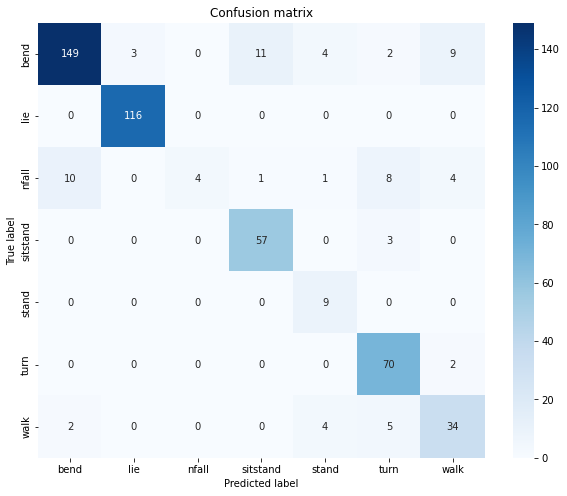

Accuracy: 0.8642


In [ ]:
### CHECK ON NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_squeezenet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

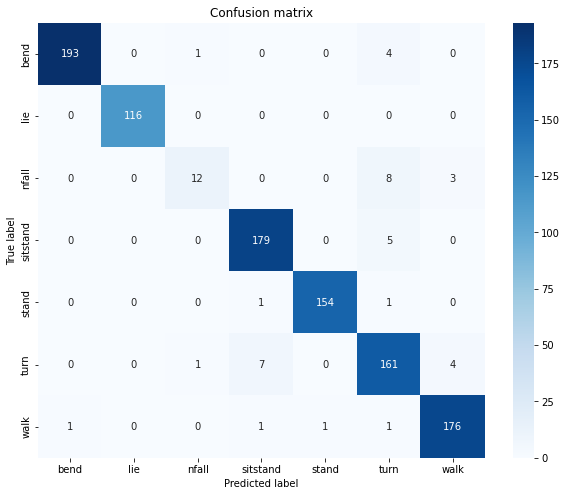

Accuracy: 0.9621


In [ ]:
### CHECK ON Flipped image on NEW PATIENT

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_resnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

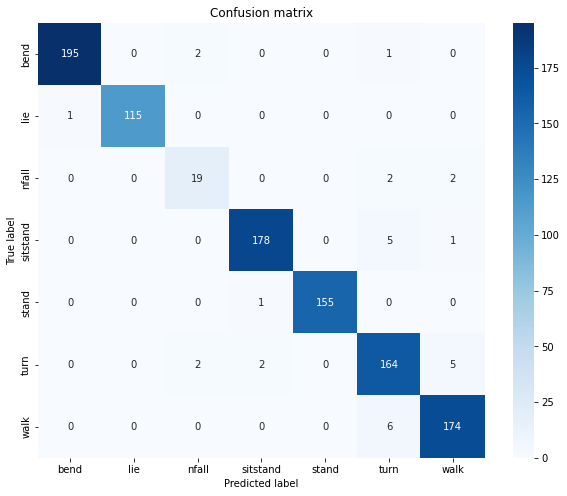

Accuracy: 0.9709


In [ ]:
### CHECK ON Flipped image

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

In [ ]:
### CHECK ON Sequence

# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

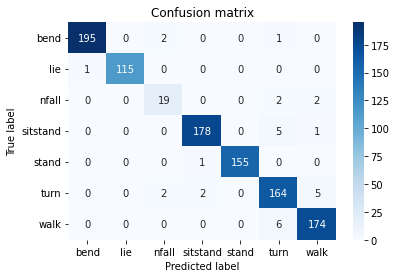

Accuracy: 0.9709


In [ ]:
model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/HG_alexnet_false")
# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataHG"

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)

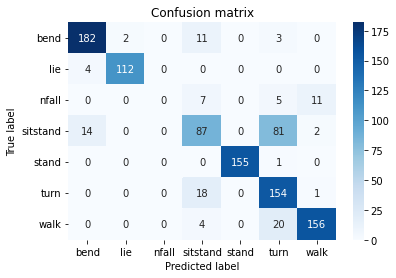

Accuracy: 0.8214


In [ ]:
# Data directory
data_dir = "drive/MyDrive/Thesis/Codes/ImageNet/dataAcc3"

model = torch.load("drive/MyDrive/Thesis/Codes/ImageNet/acc3_alexnet_false")

Y_pred, Y_label  = get_all_preds(model,data_dir)
plot_conf(Y_pred, Y_label)